## GAN (chest_xray)

In [1]:
import os
import random
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

### Data preparation

In [ ]:
class PneumoniaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        # Load pneumonia data
        pneumonia_dir = os.path.join(root_dir, "pneumonia")
        for img_name in os.listdir(pneumonia_dir):
            label = 0 if "bacteria" in img_name else 1
            self.image_paths.append(os.path.join(pneumonia_dir, img_name))
            self.labels.append(label)

        # Load normal data
        normal_dir = os.path.join(root_dir, "normal")
        for img_name in os.listdir(normal_dir):
            self.image_paths.append(os.path.join(normal_dir, img_name))
            self.labels.append(2)  # Normal

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


# Define transformations
transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # For GAN training
    ]
)


mix_dir = os.path.join(".\chest_xray", "mix")
dataset = PneumoniaDataset(mix_dir, transform=transform)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### def GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 64 * 64 * img_channels),
            nn.Tanh(),
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), 3, 64, 64)


class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64 * img_channels, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        return self.model(img)

### Def classifier

In [ ]:
class Classifier(nn.Module):
    def __init__(self, num_classes=3):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 64 * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, img):
        return self.model(img)

### Train loop

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
classifier = Classifier().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)
optimizer_C = optim.Adam(classifier.parameters(), lr=0.001)

# Loss functions
adversarial_loss = nn.BCELoss()
classification_loss = nn.CrossEntropyLoss()

for epoch in range(150):
    for real_imgs, labels in train_loader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)

        # --- Train Discriminator ---
        z = torch.randn(real_imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)

        real_validity = discriminator(real_imgs)
        fake_validity = discriminator(fake_imgs.detach())
        real_loss = adversarial_loss(real_validity, torch.ones_like(real_validity))
        fake_loss = adversarial_loss(fake_validity, torch.zeros_like(fake_validity))
        d_loss = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        fake_validity = discriminator(fake_imgs)
        classification = classifier(fake_imgs)
        g_loss = adversarial_loss(
            fake_validity, torch.ones_like(fake_validity)
        ) + classification_loss(classification, labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # --- Train Classifier ---
        real_classification = classifier(real_imgs)
        c_loss_real = classification_loss(real_classification, labels)

        optimizer_C.zero_grad()
        c_loss_real.backward()
        optimizer_C.step()

    print(
        f"Epoch {epoch + 1}: D_loss: {d_loss.item()}, G_loss: {g_loss.item()}, C_loss: {c_loss_real.item()}"
    )

Epoch 1: D_loss: 0.058575116097927094, G_loss: 3.5434083938598633, C_loss: 0.5362995266914368
Epoch 2: D_loss: 0.03386630117893219, G_loss: 5.063937187194824, C_loss: 0.49865350127220154
Epoch 3: D_loss: 0.2359081506729126, G_loss: 2.8563642501831055, C_loss: 0.21310222148895264
Epoch 4: D_loss: 0.20090684294700623, G_loss: 2.65976619720459, C_loss: 0.7900468707084656
Epoch 5: D_loss: 0.17841628193855286, G_loss: 3.4075541496276855, C_loss: 0.47134900093078613
Epoch 6: D_loss: 0.036194778978824615, G_loss: 5.457849502563477, C_loss: 0.2540764808654785
Epoch 7: D_loss: 0.06985259801149368, G_loss: 4.9046125411987305, C_loss: 0.6293923258781433
Epoch 8: D_loss: 0.1252201646566391, G_loss: 5.003284931182861, C_loss: 0.7093382477760315
Epoch 9: D_loss: 0.3069184124469757, G_loss: 3.8124589920043945, C_loss: 0.420634388923645
Epoch 10: D_loss: 0.01262829639017582, G_loss: 8.8043794631958, C_loss: 0.317884624004364
Epoch 11: D_loss: 0.05137837678194046, G_loss: 8.813754081726074, C_loss: 0.4

### Evaluation

In [16]:
# Evaluate classifier on test set
classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = classifier(imgs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 76.62%


### Confusion Matrix

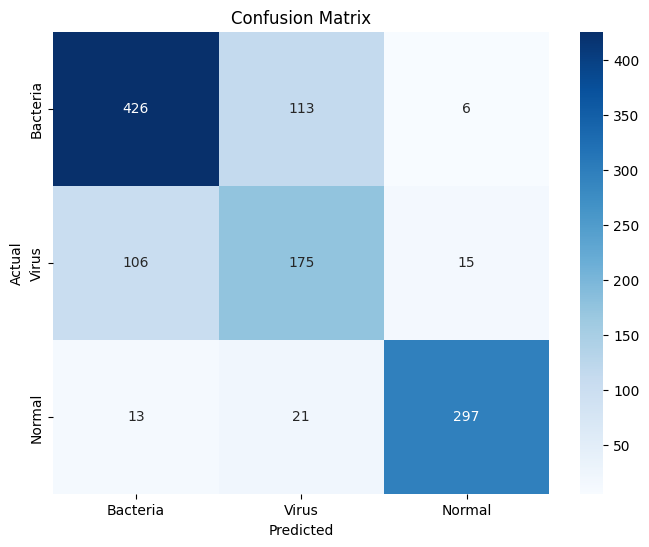

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Step 1: Collect Predictions and Ground Truth ---

y_true = []  # Ground truth labels
y_pred = []  # Predicted labels

# Switch classifier to evaluation mode
classifier.eval()

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = classifier(imgs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- Step 2: Compute Confusion Matrix ---
class_names = ["Bacteria", "Virus", "Normal"]  # Class names
cm = confusion_matrix(y_true, y_pred)

# --- Step 3: Plot Confusion Matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()